Cupy non disponible : utilisation de NumPy.


C:\Users\Dell\AppData\Local\Temp\ipykernel_14584\1212282707.py:174: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  timestamp = pd.to_datetime(timestamp)


Solver status: Optimal
Total flexibility cost (EUR): -11048166996.662401


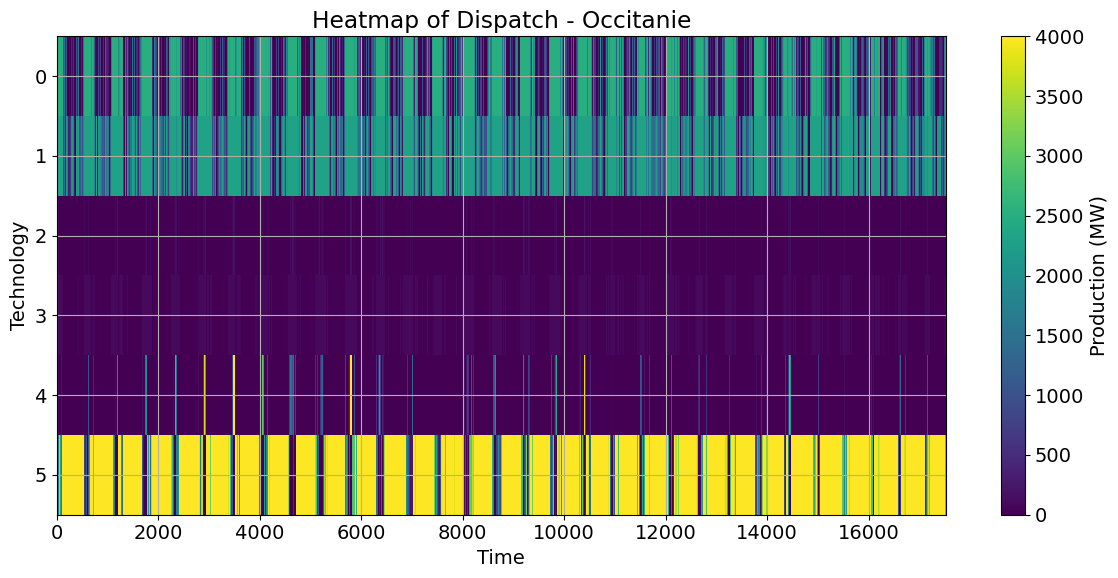

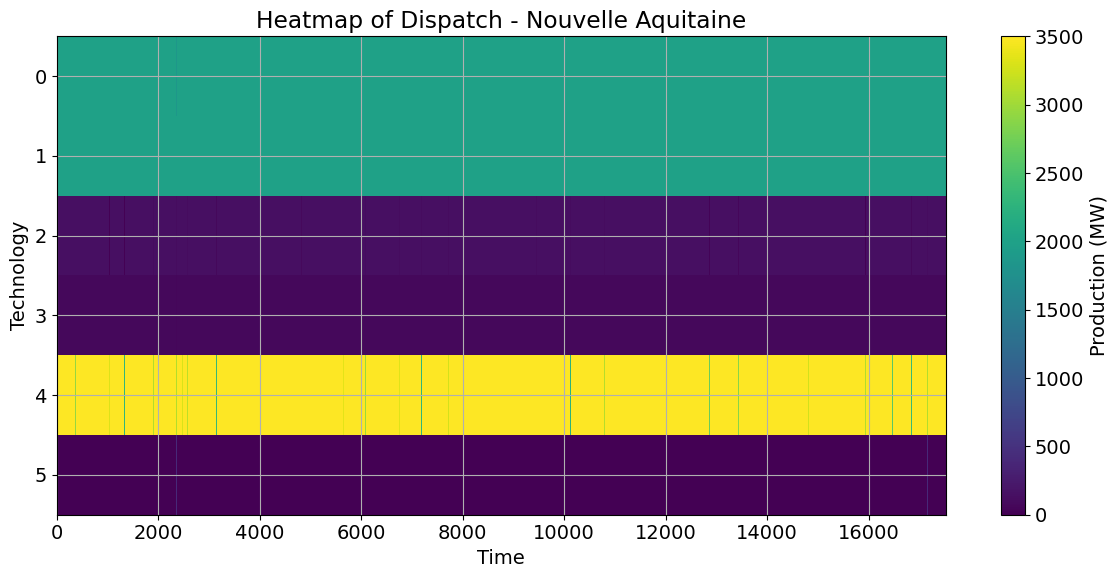

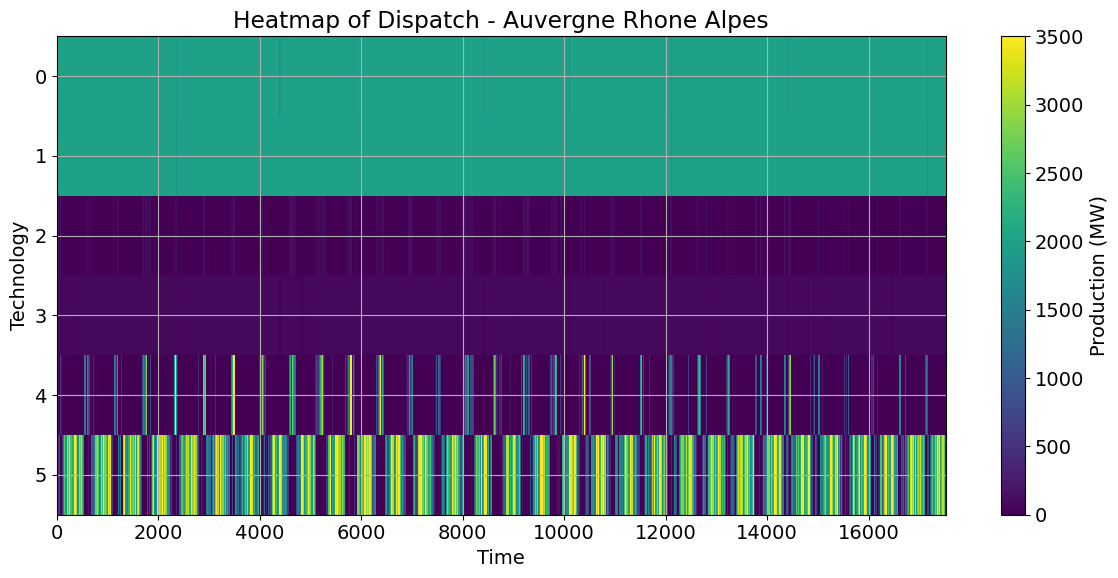

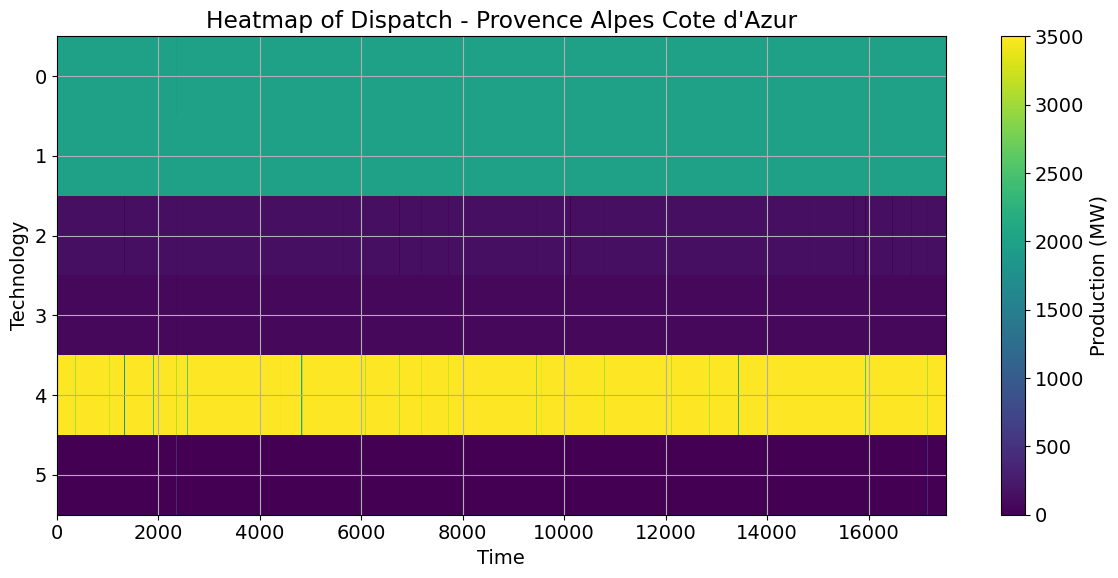

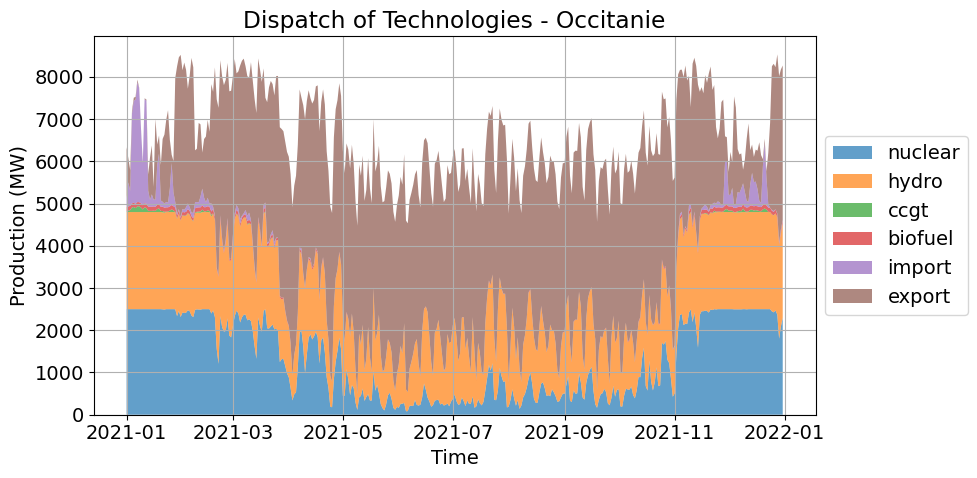

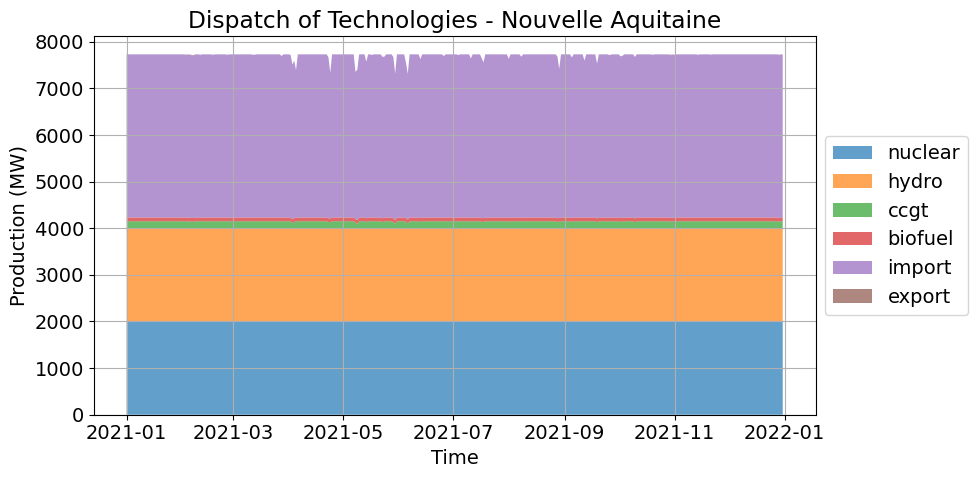

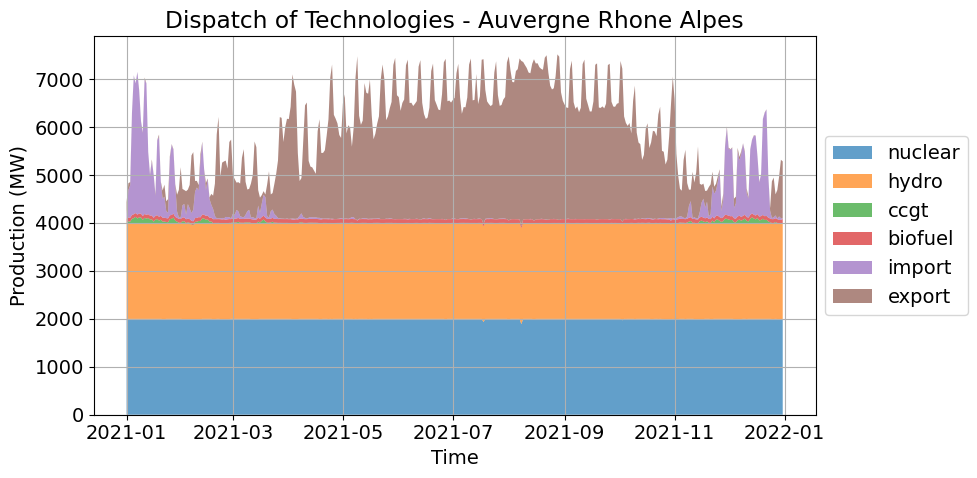

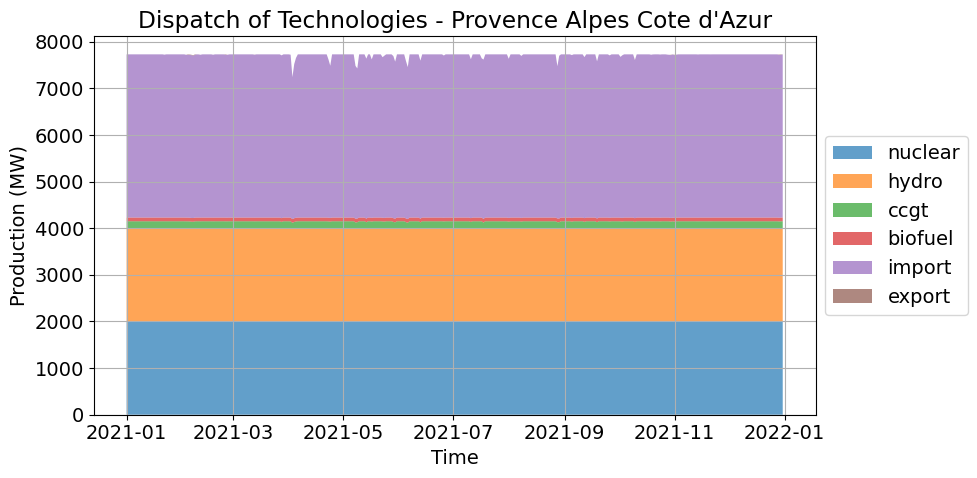

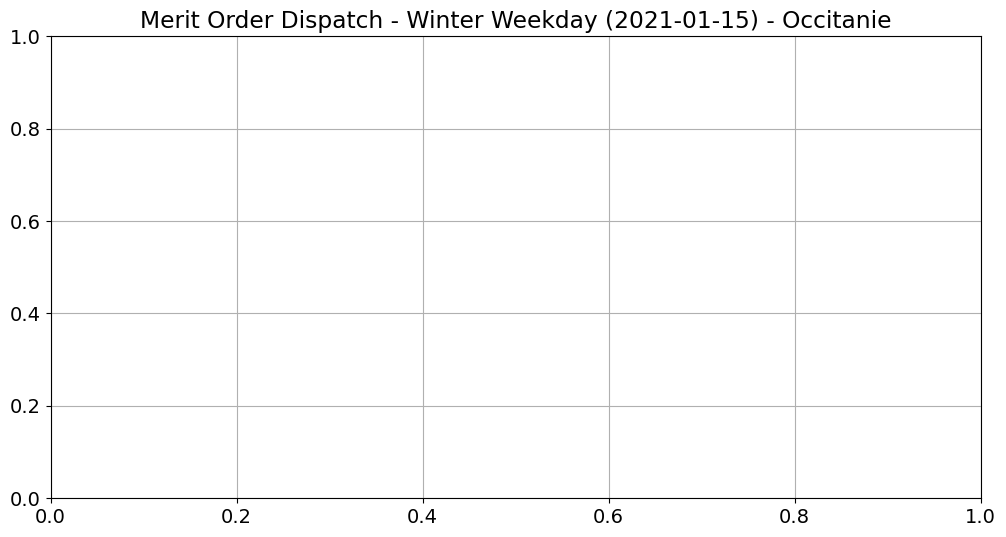

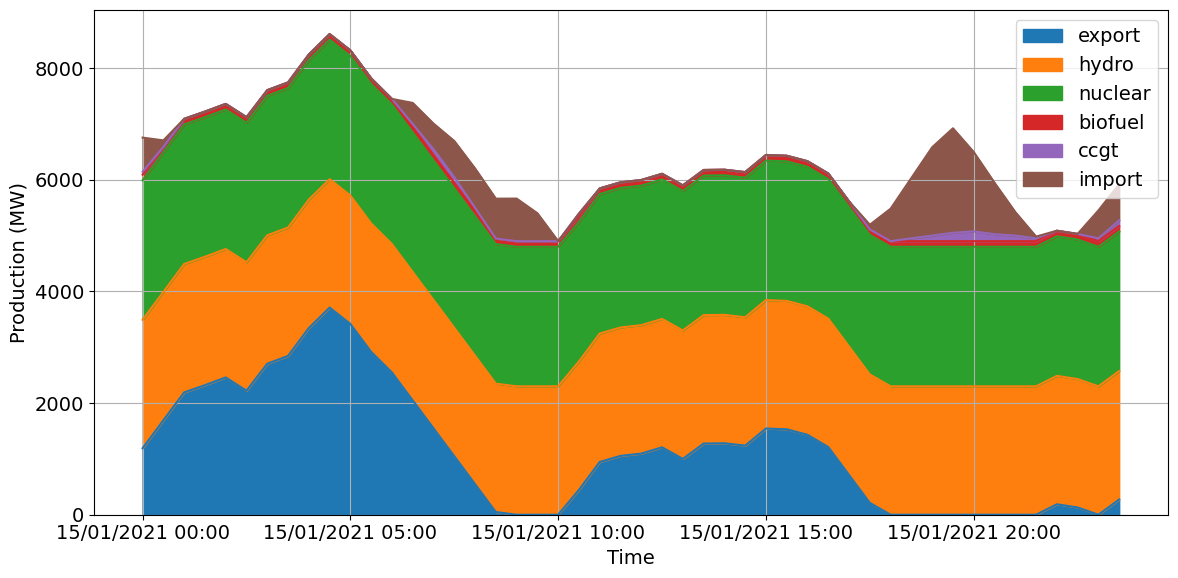

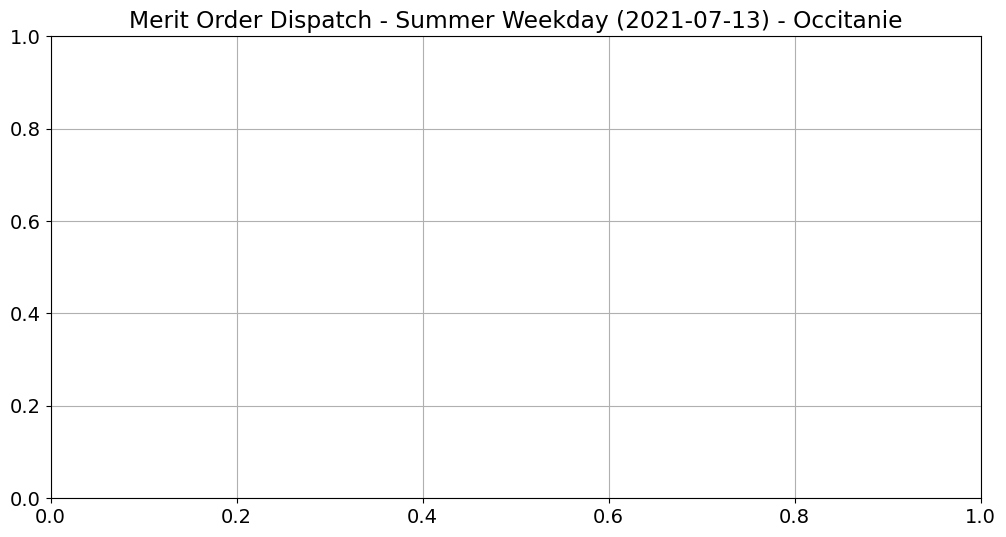

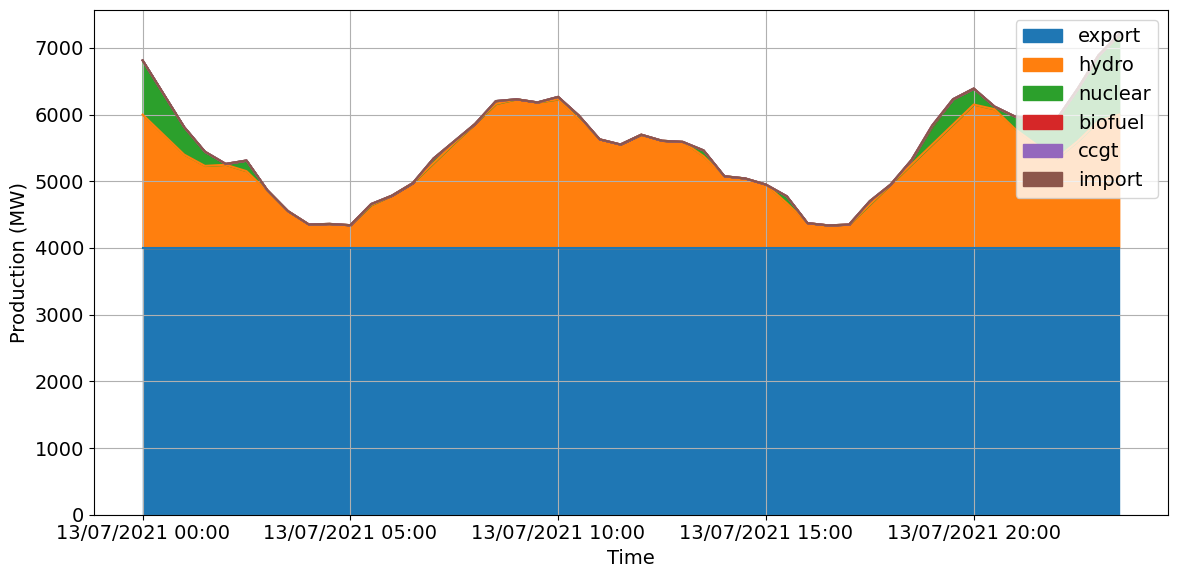

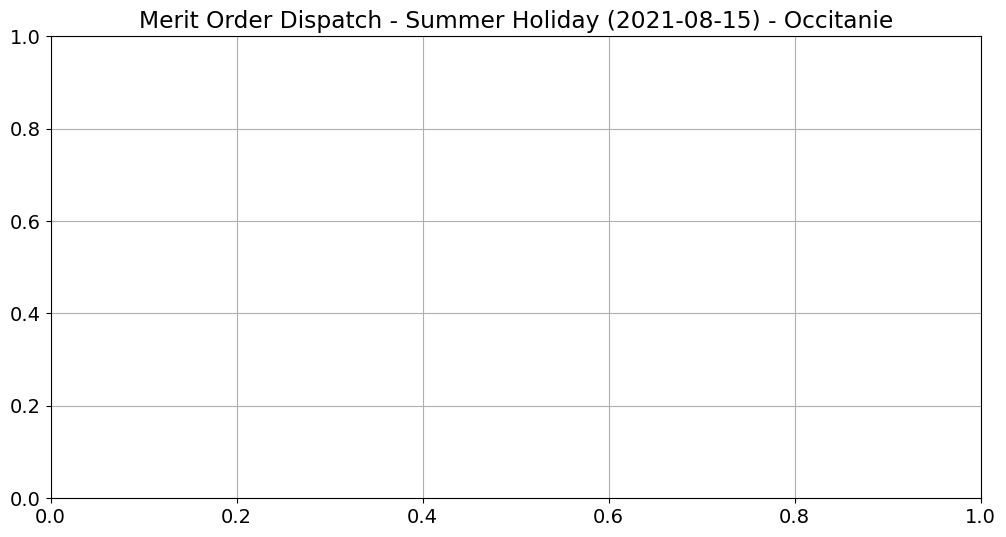

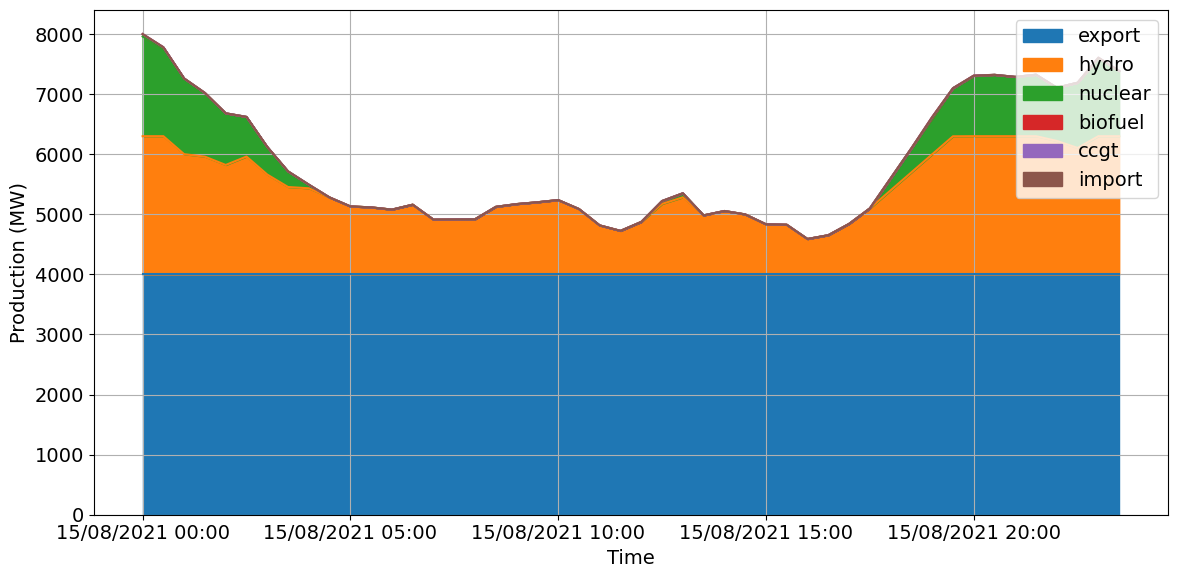

In [7]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
from datetime import datetime

# Update Matplotlib parameters for readability and white backgrounds
plt.rcParams.update({
    'font.size': 14,
    'figure.figsize': (12, 6),
    'axes.grid': True,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

# Attempt to import Cupy for GPU acceleration
try:
    import cupy as cp
    gpu_available = True   # Change to True if you want to use GPU acceleration
    print("Cupy importé : accélération GPU activée pour les calculs numériques.")
except ImportError:
    gpu_available = False
    print("Cupy non disponible : utilisation de NumPy.")

# ----------------------------------------------------------------------
# 1. USER SETTINGS
# ----------------------------------------------------------------------
DATA_FILE = "C:/Users/Dell/projects/regional_flex/Data/multi_region_data.csv"  # CSV file containing, for each region,
                                      # the columns {region}_demand_MW, {region}_solar_MW, {region}_wind_MW
TIME_RES_MINS = 30                   # Time resolution in minutes
SPILL_COST = 80                      # Curtailment cost (€/MWh)
YEAR = 2021

# List of regions
REGIONS = [
    "Occitanie",
    "Nouvelle Aquitaine",
    "Auvergne Rhone Alpes",
    "Provence Alpes Cote d'Azur"
]

# Global capacity and base cost for interregional exchanges (in MW)
EXCHANGE_CAPACITY = 4000
EXCHANGE_COST = 80

# --- New: Demand Response (DR) parameters ---
# DR_CAP sets the maximum DR capacity (in MW)
# DR_COST sets the variable marginal cost (€/MWh) of activating DR
# DR_FIXED_COST sets a fixed cost incurred each time DR is activated
DR_CAP = {
    "Occitanie": 500,
    "Nouvelle Aquitaine": 400,
    "Auvergne Rhone Alpes": 450,
    "Provence Alpes Cote d'Azur": 350
}
DR_COST = {
    "Occitanie": 30,
    "Nouvelle Aquitaine": 30,
    "Auvergne Rhone Alpes": 30,
    "Provence Alpes Cote d'Azur": 30
}
DR_FIXED_COST = {
    "Occitanie": 50,
    "Nouvelle Aquitaine": 50,
    "Auvergne Rhone Alpes": 50,
    "Provence Alpes Cote d'Azur": 50
}

# Renewable uncertainty factor (set to 0 for no uncertainty; can be positive or negative for sensitivity analysis)
renewable_uncertainty = 0.0

# ----------------------------------------------------------------------
# 2. DATA LOADING FOR MULTI-REGIONS
# ----------------------------------------------------------------------
def load_data_multi():
    """
    Loads the CSV file containing data for each region.
    Expected columns for each region: {region}_demand_MW, {region}_solar_MW, {region}_wind_MW.
    Returns a dictionary: data[region] = DataFrame indexed by timestamp.
    """
    df = pd.read_csv(DATA_FILE, sep=";", parse_dates=['timestamp'], index_col='timestamp')
    df = df.sort_index()
    data = {}
    for r in REGIONS:
        cols = [f"{r}_demand_MW", f"{r}_solar_MW", f"{r}_wind_MW"]
        df_region = df[cols].copy()
        # Rename columns for uniformity
        df_region.columns = ["demand_MW", "solar_MW", "wind_MW"]
        data[r] = df_region
    return data

# ----------------------------------------------------------------------
# 3. DEFINE REGION-SPECIFIC TECHNOLOGIES
# ----------------------------------------------------------------------
def define_region_technologies():
    """
    Returns two dictionaries:
      - tech_by_region: parameters of dispatchable technologies for each region.
      - storage_by_region: storage parameters for each region.
    You can adjust the values (capacity, costs, etc.) for each region.
    Some new parameters:
      - "ramp_up": maximum increase per time step.
      - "ramp_down": maximum decrease per time step.
    """
    tech_by_region = {}
    storage_by_region = {}

    # Example parameters for Occitanie
    tech_by_region["Occitanie"] = {
         "nuclear": {"direction": "positive", "max_cap": 2500, "min_cap": 500, "marg_cost": 13, "ramp_up": 200, "ramp_down": 200},
         "hydro":   {"direction": "positive", "max_cap": 2300, "min_cap": 0,   "marg_cost": 10, "ramp_up": 300, "ramp_down": 300},
         "ccgt":    {"direction": "positive", "max_cap": 180,  "min_cap": 0,   "marg_cost": 40, "ramp_up": 50,  "ramp_down": 50},
         "biofuel": {"direction": "positive", "max_cap": 100,  "min_cap": 0,   "marg_cost": 20, "ramp_up": 20,  "ramp_down": 20},
         "import":  {"direction": "positive", "max_cap": 4000, "min_cap": 0,   "marg_cost": 40, "ramp_up": 500, "ramp_down": 500},
         "export":  {"direction": "export",   "max_cap": 4000, "min_cap": 0,   "marg_cost": -40, "ramp_up": 500, "ramp_down": 500}
    }
    storage_by_region["Occitanie"] = {
         "phs":     {"max_power": 1500, "capacity_MWh": 1500, "eff_charge": 0.85, "eff_discharge": 0.85,
                     "self_discharge_rate": 0.0, "marg_cost": 35, "initial_soc": 0.5,
                     "max_charge_change": 300, "max_discharge_change": 300},
         "battery": {"max_power": 50,   "capacity_MWh": 50,   "eff_charge": 0.9,  "eff_discharge": 0.9,
                     "self_discharge_rate": 0.05, "marg_cost": 80, "initial_soc": 0.5,
                     "max_charge_change": 10, "max_discharge_change": 10}
    }

    # For other regions (example values)
    for r in REGIONS:
        if r not in tech_by_region:
            tech_by_region[r] = {
                "nuclear": {"direction": "positive", "max_cap": 2000, "min_cap": 400, "marg_cost": 13, "ramp_up": 150, "ramp_down": 150},
                "hydro":   {"direction": "positive", "max_cap": 2000, "min_cap": 0,   "marg_cost": 10, "ramp_up": 250, "ramp_down": 250},
                "ccgt":    {"direction": "positive", "max_cap": 150,  "min_cap": 0,   "marg_cost": 40, "ramp_up": 40,  "ramp_down": 40},
                "biofuel": {"direction": "positive", "max_cap": 80,   "min_cap": 0,   "marg_cost": 20, "ramp_up": 15,  "ramp_down": 15},
                "import":  {"direction": "positive", "max_cap": 3500, "min_cap": 0,   "marg_cost": 40, "ramp_up": 400, "ramp_down": 400},
                "export":  {"direction": "export",   "max_cap": 3500, "min_cap": 0,   "marg_cost": -40, "ramp_up": 400, "ramp_down": 400}
            }
            storage_by_region[r] = {
                "phs":     {"max_power": 1200, "capacity_MWh": 1200, "eff_charge": 0.85, "eff_discharge": 0.85,
                            "self_discharge_rate": 0.0, "marg_cost": 35, "initial_soc": 0.5,
                            "max_charge_change": 250, "max_discharge_change": 250},
                "battery": {"max_power": 40,   "capacity_MWh": 40,   "eff_charge": 0.9,  "eff_discharge": 0.9,
                            "self_discharge_rate": 0.05, "marg_cost": 80, "initial_soc": 0.5,
                            "max_charge_change": 8, "max_discharge_change": 8}
            }
    return tech_by_region, storage_by_region

# ----------------------------------------------------------------------
# 4. DETECT POTENTIALLY INFEASIBLE PERIODS (by region)
# ----------------------------------------------------------------------
def detect_infeasibility_multi(data_dict, tech_by_region, storage_by_region):
    """
    For each region, estimate the maximum local flexible capacity and check if the exogenous demand exceeds it (heuristic).
    """
    infeas_dict = {}
    for r, df in data_dict.items():
        load = df["demand_MW"]
        local_tech = tech_by_region[r]
        local_storage = storage_by_region[r]
        max_flex = sum(p["max_cap"] for p in local_tech.values() if p["direction"] in ["positive", "export"]) \
                   + sum(s["max_power"] for s in local_storage.values())
        dfr = pd.DataFrame(index=load.index)
        dfr["load"] = load
        dfr["over_capacity"] = load > max_flex
        dfr["likely_infeasible"] = dfr["over_capacity"]
        infeas_dict[r] = dfr
    return infeas_dict

# ----------------------------------------------------------------------
# Function to get dynamic exchange cost based on time (e.g., higher during peak hours)
# ----------------------------------------------------------------------
def get_dynamic_exchange_cost(timestamp):
    # Convertir le timestamp en objet datetime s'il s'agit d'une chaîne
    if not isinstance(timestamp, datetime):
        timestamp = pd.to_datetime(timestamp)
    # Assume peak hours between 17:00 and 21:00
    if 17 <= timestamp.hour <= 21:
        return EXCHANGE_COST * 1.5
    else:
        return EXCHANGE_COST

# ----------------------------------------------------------------------
# 5. CONSTRUCT AND SOLVE THE INTERREGIONAL MODEL
# ----------------------------------------------------------------------
def build_and_solve_model_multi(data_dict, tech_by_region, storage_by_region, time_index):
    """
    Constructs the interregional LP model including:
      - Variables for dispatchable technologies, storage, and renewables.
      - Renewable availability constraints (with an uncertainty multiplier).
      - Dynamic storage modeling with additional rate-of-change constraints.
      - Ramp rate constraints for dispatchable technologies.
      - Local balance constraints: flexible production (dispatch, storage, exchanges) must cover residual demand (demand minus renewables and DR).
      - Interregional exchange variables (only for certain authorized pairs) with dynamic pricing.
      - Slack variables with high penalties to ensure feasibility.
      - Demand Response (DR) variables, with binary activation and fixed costs.
    """
    model = pulp.LpProblem("Interregional_Optimization", pulp.LpMinimize)

    # Region-specific variables
    dispatch_vars = {}     # Dispatchable production by region
    solar_flow = {}
    solar_spill = {}
    wind_flow = {}
    wind_spill = {}
    storage_charge = {}
    storage_discharge = {}
    soc_vars = {}

    for r in REGIONS:
        local_tech = tech_by_region[r]
        local_storage = storage_by_region[r]
        dispatch_vars[r] = {}
        # Create dispatch variables and add ramp rate constraints if available
        tlist = list(time_index)
        for name, p in local_tech.items():
            dispatch_vars[r][name] = pulp.LpVariable.dicts(
                f"flow_{r}_{name}",
                time_index,
                lowBound=0,
                upBound=p["max_cap"],
                cat=pulp.LpContinuous
            )
            # Add ramp rate constraints if parameters are defined
            if "ramp_up" in p and "ramp_down" in p:
                for i in range(len(tlist)-1):
                    t_current = tlist[i]
                    t_next = tlist[i+1]
                    model += (dispatch_vars[r][name][t_next] - dispatch_vars[r][name][t_current]
                              <= p["ramp_up"]), f"RampUp_{r}_{name}_{t_current}"
                    model += (dispatch_vars[r][name][t_current] - dispatch_vars[r][name][t_next]
                              <= p["ramp_down"]), f"RampDown_{r}_{name}_{t_current}"

        solar_flow[r] = pulp.LpVariable.dicts(f"flow_solar_{r}", time_index, lowBound=0, cat=pulp.LpContinuous)
        solar_spill[r] = pulp.LpVariable.dicts(f"spill_solar_{r}", time_index, lowBound=0, cat=pulp.LpContinuous)
        wind_flow[r] = pulp.LpVariable.dicts(f"flow_wind_{r}", time_index, lowBound=0, cat=pulp.LpContinuous)
        wind_spill[r] = pulp.LpVariable.dicts(f"spill_wind_{r}", time_index, lowBound=0, cat=pulp.LpContinuous)

        storage_charge[r] = {}
        storage_discharge[r] = {}
        soc_vars[r] = {}
        for st, s in local_storage.items():
            storage_charge[r][st] = pulp.LpVariable.dicts(
                f"flow_charge_{r}_{st}",
                time_index,
                lowBound=0,
                upBound=s["max_power"],
                cat=pulp.LpContinuous
            )
            storage_discharge[r][st] = pulp.LpVariable.dicts(
                f"flow_discharge_{r}_{st}",
                time_index,
                lowBound=0,
                upBound=s["max_power"],
                cat=pulp.LpContinuous
            )
            soc_vars[r][st] = pulp.LpVariable.dicts(
                f"soc_{r}_{st}",
                time_index,
                lowBound=0,
                upBound=s["capacity_MWh"],
                cat=pulp.LpContinuous
            )

            # Additional storage rate constraints if defined
            for i in range(len(tlist)-1):
                t_current = tlist[i]
                t_next = tlist[i+1]
                if "max_charge_change" in s:
                    # Define an auxiliary variable for the absolute change in charging
                    delta_charge = pulp.LpVariable(f"delta_charge_{r}_{st}_{t_current}", lowBound=0)
                    model += delta_charge >= storage_charge[r][st][t_next] - storage_charge[r][st][t_current], f"ChargeDeltaPos_{r}_{st}_{t_current}"
                    model += delta_charge >= -(storage_charge[r][st][t_next] - storage_charge[r][st][t_current]), f"ChargeDeltaNeg_{r}_{st}_{t_current}"
                    model += delta_charge <= s["max_charge_change"], f"ChargeChange_{r}_{st}_{t_current}"
                if "max_discharge_change" in s:
                    # Define an auxiliary variable for the absolute change in discharging
                    delta_discharge = pulp.LpVariable(f"delta_discharge_{r}_{st}_{t_current}", lowBound=0)
                    model += delta_discharge >= storage_discharge[r][st][t_next] - storage_discharge[r][st][t_current], f"DischargeDeltaPos_{r}_{st}_{t_current}"
                    model += delta_discharge >= -(storage_discharge[r][st][t_next] - storage_discharge[r][st][t_current]), f"DischargeDeltaNeg_{r}_{st}_{t_current}"
                    model += delta_discharge <= s["max_discharge_change"], f"DischargeChange_{r}_{st}_{t_current}"

        # Renewable availability constraints (with uncertainty factor)
        df_region = data_dict[r]
        for t in time_index:
            model += (solar_flow[r][t] + solar_spill[r][t] == df_region.loc[t, "solar_MW"] * (1 + renewable_uncertainty)), f"SolarAvail_{r}_{t}"
            model += (wind_flow[r][t] + wind_spill[r][t] == df_region.loc[t, "wind_MW"] * (1 + renewable_uncertainty)), f"WindAvail_{r}_{t}"

        # Dynamic storage modeling
        for st, s in local_storage.items():
            eff_c = s["eff_charge"]
            eff_d = s["eff_discharge"]
            sd = s["self_discharge_rate"]
            init_soc = s["initial_soc"] * s["capacity_MWh"]
            tlist = list(time_index)
            for i, ts in enumerate(tlist):
                if i == 0:
                    model += (soc_vars[r][st][ts]
                              == init_soc
                              + storage_charge[r][st][ts] * eff_c * (TIME_RES_MINS/60.0)
                              - storage_discharge[r][st][ts] * (1.0/eff_d) * (TIME_RES_MINS/60.0)
                             ), f"SOC_init_{r}_{st}_{ts}"
                else:
                    ts_prev = tlist[i-1]
                    model += (soc_vars[r][st][ts]
                              == soc_vars[r][st][ts_prev]*(1 - sd)
                              + storage_charge[r][st][ts] * eff_c * (TIME_RES_MINS/60.0)
                              - storage_discharge[r][st][ts] * (1.0/eff_d) * (TIME_RES_MINS/60.0)
                             ), f"SOC_{r}_{st}_{ts}"
                model += soc_vars[r][st][ts] >= 0, f"SoCmin_{r}_{st}_{ts}"
                model += soc_vars[r][st][ts] <= s["capacity_MWh"], f"SoCmax_{r}_{st}_{ts}"

    # Interregional exchange variables (only for authorized pairs)
    allowed_pairs = [
        ("Occitanie", "Nouvelle Aquitaine"),
        ("Occitanie", "Auvergne Rhone Alpes"),
        ("Occitanie", "Provence Alpes Cote d'Azur"),
        ("Auvergne Rhone Alpes", "Provence Alpes Cote d'Azur"),
        ("Auvergne Rhone Alpes", "Nouvelle Aquitaine")
    ]
    exchange_vars = {}
    for (r1, r2) in allowed_pairs:
        exchange_vars[(r1, r2)] = pulp.LpVariable.dicts(
            f"exchange_{r1}_{r2}",
            time_index,
            lowBound=-EXCHANGE_CAPACITY,
            upBound=EXCHANGE_CAPACITY,
            cat=pulp.LpContinuous
        )

    # Slack variables to guarantee feasibility
    cost_slack = 1e6  # Very high penalty (€/MWh)
    slack_shed = {}
    slack_dump = {}
    for r in REGIONS:
        slack_shed[r] = pulp.LpVariable.dicts(f"shed_{r}", time_index, lowBound=0, cat=pulp.LpContinuous)
        slack_dump[r] = pulp.LpVariable.dicts(f"dump_{r}", time_index, lowBound=0, cat=pulp.LpContinuous)

    # ----------------------------------------------------------------------
    # Demand Response (DR) Variables and Binary Activation (Commented Out)
    # ----------------------------------------------------------------------
    # The following section defines DR variables and associated binary variables that enable a fixed cost
    # to be applied whenever DR is activated.
    # We comment these lines out if we wish to disable the binary activation mechanism.
    dr_vars = {}
    # dr_bin = {}
    for r in REGIONS:
        dr_vars[r] = pulp.LpVariable.dicts(f"DR_{r}", time_index, lowBound=0, upBound=DR_CAP[r], cat=pulp.LpContinuous)
        # dr_bin[r] = pulp.LpVariable.dicts(f"DR_bin_{r}", time_index, cat=pulp.LpBinary)
        for t in time_index:
            # model += (dr_vars[r][t] <= DR_CAP[r] * dr_bin[r][t]), f"DR_bin_bound_{r}_{t}"
            pass
    # ----------------------------------------------------------------------
    
    # Regional balance constraints:
    # Flexible production (dispatch + net storage + exchanges) must cover the residual demand
    # (demand minus renewables and DR).
    for r in REGIONS:
        local_tech = tech_by_region[r]
        local_storage = storage_by_region[r]
        df_region = data_dict[r]
        for t in time_index:
            lhs_terms = []
            # Dispatchable production
            for name, p in local_tech.items():
                if p["direction"] == "positive":
                    lhs_terms.append(dispatch_vars[r][name][t])
                elif p["direction"] == "export":
                    lhs_terms.append(-dispatch_vars[r][name][t])
            # Net storage contribution
            for st in local_storage.keys():
                lhs_terms.append(storage_discharge[r][st][t] - storage_charge[r][st][t])
            # Interregional exchanges
            for (r1, r2), ex_var in exchange_vars.items():
                if r == r1:
                    lhs_terms.append(-ex_var[t])
                elif r == r2:
                    lhs_terms.append(ex_var[t])
            model += (pulp.lpSum(lhs_terms) + slack_shed[r][t] - slack_dump[r][t] ==
                      df_region.loc[t, "demand_MW"] - (solar_flow[r][t] + wind_flow[r][t]) - dr_vars[r][t]
                     ), f"Balance_{r}_{t}"

    # Objective function: minimize total costs (flexible production, storage, curtailment, exchanges,
    # DR variable costs and fixed activation costs, and penalties)
    cost_terms = []
    for r in REGIONS:
        local_tech = tech_by_region[r]
        local_storage = storage_by_region[r]
        # Dispatchable production costs
        for name, p in local_tech.items():
            for t in time_index:
                cost_terms.append(dispatch_vars[r][name][t] * p["marg_cost"])
        # Storage discharge costs
        for st, s in local_storage.items():
            for t in time_index:
                cost_terms.append(storage_discharge[r][st][t] * s["marg_cost"])
        # Curtailment penalties for renewables
        for t in time_index:
            cost_terms.append(solar_spill[r][t] * SPILL_COST)
            cost_terms.append(wind_spill[r][t] * SPILL_COST)
    # Interregional exchange costs (using dynamic pricing)
    for (r1, r2), ex_var in exchange_vars.items():
        for t in time_index:
            cost_terms.append(ex_var[t] * get_dynamic_exchange_cost(t))
    # Slack penalties (load shedding and dumping)
    for r in REGIONS:
        for t in time_index:
            cost_terms.append(slack_shed[r][t] * cost_slack)
            cost_terms.append(slack_dump[r][t] * cost_slack)
    # Demand Response variable costs and fixed activation costs
    for r in REGIONS:
        for t in time_index:
            cost_terms.append(dr_vars[r][t] * DR_COST[r])
            # cost_terms.append(dr_bin[r][t] * DR_FIXED_COST[r])
    
    model += pulp.lpSum(cost_terms), "Total_Cost"

    # Solve the model
    model_status = model.solve(pulp.PULP_CBC_CMD(msg=0))
    status_str = pulp.LpStatus[model_status]

    # Extract results into a data structure
    results = {"status": status_str, "total_cost": pulp.value(model.objective)}
    results["dispatch"] = {r: {} for r in REGIONS}
    results["solar"] = {r: pd.DataFrame(index=time_index) for r in REGIONS}
    results["wind"] = {r: pd.DataFrame(index=time_index) for r in REGIONS}
    results["storage_charge"] = {r: {} for r in REGIONS}
    results["storage_discharge"] = {r: {} for r in REGIONS}
    results["soc"] = {r: {} for r in REGIONS}
    results["exchange"] = {}

    for r in REGIONS:
        local_tech = tech_by_region[r]
        local_storage = storage_by_region[r]
        for name in local_tech.keys():
            results["dispatch"][r][name] = [pulp.value(dispatch_vars[r][name][t]) for t in time_index]
        results["solar"][r]["flow_solar"] = [pulp.value(solar_flow[r][t]) for t in time_index]
        results["solar"][r]["spill_solar"] = [pulp.value(solar_spill[r][t]) for t in time_index]
        results["wind"][r]["flow_wind"] = [pulp.value(wind_flow[r][t]) for t in time_index]
        results["wind"][r]["spill_wind"] = [pulp.value(wind_spill[r][t]) for t in time_index]
        for st in local_storage.keys():
            results["storage_charge"][r][st] = [pulp.value(storage_charge[r][st][t]) for t in time_index]
            results["storage_discharge"][r][st] = [pulp.value(storage_discharge[r][st][t]) for t in time_index]
            results["soc"][r][st] = [pulp.value(soc_vars[r][st][t]) for t in time_index]

    for (r1, r2), ex_var in exchange_vars.items():
        results["exchange"][f"{r1}_{r2}"] = [pulp.value(ex_var[t]) for t in time_index]

    # Extract Demand Response results
    results["demand_response"] = {}
    for r in REGIONS:
        results["demand_response"][r] = [pulp.value(dr_vars[r][t]) for t in time_index]

    # Convert slack results for fast visualization
    if gpu_available:
        for r in REGIONS:
            results.setdefault("slack_shed", {})[r] = cp.array([pulp.value(slack_shed[r][t]) for t in time_index])
            results.setdefault("slack_dump", {})[r] = cp.array([pulp.value(slack_dump[r][t]) for t in time_index])
    else:
        for r in REGIONS:
            results.setdefault("slack_shed", {})[r] = np.array([pulp.value(slack_shed[r][t]) for t in time_index])
            results.setdefault("slack_dump", {})[r] = np.array([pulp.value(slack_dump[r][t]) for t in time_index])

    return model, results

# ----------------------------------------------------------------------
# 6. MAIN
# ----------------------------------------------------------------------
def main():
    data_dict = load_data_multi()
    sample_region = REGIONS[0]
    time_index = data_dict[sample_region].index

    tech_by_region, storage_by_region = define_region_technologies()
    infeas_dict = detect_infeasibility_multi(data_dict, tech_by_region, storage_by_region)
    # Save infeasible periods for each region as CSV files
    for r, df_inf in infeas_dict.items():
        df_inf.reset_index().rename(columns={"index": "timestamp"}).to_csv(f"likely_infeasible_periods_{r}.csv", index=False)

    model, results = build_and_solve_model_multi(data_dict, tech_by_region, storage_by_region, time_index)

    print("Solver status:", results["status"])
    print("Total flexibility cost (EUR):", results["total_cost"])

    if results["status"] in ("Infeasible", "Undefined"):
        print("Le modèle n'a pas trouvé de solution faisable.")
        return

    # --- Save output results to CSV files ---
    for r in REGIONS:
        # Dispatch
        dispatch_df = pd.DataFrame(results["dispatch"][r], index=time_index).reset_index().rename(columns={"index": "timestamp"})
        dispatch_df.to_csv(f"output_dispatch_{r}.csv", index=False)
        # Solar
        solar_df = results["solar"][r].reset_index().rename(columns={"index": "timestamp"})
        solar_df.to_csv(f"output_solar_{r}.csv", index=False)
        # Wind
        wind_df = results["wind"][r].reset_index().rename(columns={"index": "timestamp"})
        wind_df.to_csv(f"output_wind_{r}.csv", index=False)
        # Storage charge
        storage_charge_df = pd.DataFrame(results["storage_charge"][r], index=time_index).reset_index().rename(columns={"index": "timestamp"})
        storage_charge_df.to_csv(f"output_storage_charge_{r}.csv", index=False)
        # Storage discharge
        storage_discharge_df = pd.DataFrame(results["storage_discharge"][r], index=time_index).reset_index().rename(columns={"index": "timestamp"})
        storage_discharge_df.to_csv(f"output_storage_discharge_{r}.csv", index=False)
        # State of Charge (SoC)
        soc_df = pd.DataFrame(results["soc"][r], index=time_index).reset_index().rename(columns={"index": "timestamp"})
        soc_df.to_csv(f"output_soc_{r}.csv", index=False)
        # Demand Response
        dr_df = pd.DataFrame({"demand_response": results["demand_response"][r]}, index=time_index).reset_index().rename(columns={"index": "timestamp"})
        dr_df.to_csv(f"output_demand_response_{r}.csv", index=False)
        # Slack variables
        if gpu_available:
            slack_shed_array = cp.asnumpy(results["slack_shed"][r])
            slack_dump_array = cp.asnumpy(results["slack_dump"][r])
        else:
            slack_shed_array = results["slack_shed"][r]
            slack_dump_array = results["slack_dump"][r]
        slack_shed_df = pd.DataFrame({"slack_shed": slack_shed_array}, index=time_index).reset_index().rename(columns={"index": "timestamp"})
        slack_shed_df.to_csv(f"output_slack_shed_{r}.csv", index=False)
        slack_dump_df = pd.DataFrame({"slack_dump": slack_dump_array}, index=time_index).reset_index().rename(columns={"index": "timestamp"})
        slack_dump_df.to_csv(f"output_slack_dump_{r}.csv", index=False)

    for key, flows in results["exchange"].items():
        exchange_df = pd.DataFrame({f"exchange_{key}": flows}, index=time_index).reset_index().rename(columns={"index": "timestamp"})
        exchange_df.to_csv(f"output_exchange_{key}.csv", index=False)

    # --- Additional Plots ---

    # 1. Heatmap of Dispatch for each region
    for r in REGIONS:
        dispatch_df = pd.DataFrame(results["dispatch"][r], index=time_index)
        plt.figure()
        plt.title(f"Heatmap of Dispatch - {r}")
        plt.imshow(dispatch_df.T, aspect='auto', interpolation='nearest', cmap='viridis')
        plt.xlabel("Time")
        plt.ylabel("Technology")
        plt.colorbar(label="Production (MW)")
        plt.tight_layout()
        plt.show()

    # 2. Line plots of Dispatch
    for r in REGIONS:
        dispatch_df = pd.DataFrame(results["dispatch"][r], index=time_index)
        # Optionnel : échantillonnage pour plus de lisibilité (ici, moyenne journalière)
        dispatch_df.index = pd.to_datetime(dispatch_df.index, dayfirst=True)
        dispatch_daily = dispatch_df.resample("D").mean()
        plt.figure(figsize=(10, 5))
        plt.title(f"Dispatch of Technologies - {r}")
        plt.stackplot(dispatch_daily.index, dispatch_daily.T, labels=dispatch_daily.columns, alpha=0.7)
        plt.xlabel("Time")
        plt.ylabel("Production (MW)")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

    # 3. Merit Order Plots for Typical Days (for Occitanie)
    typical_dates = {
        "Winter Weekday": "2021-01-15",
        "Summer Weekday": "2021-07-13",
        "Summer Holiday": "2021-08-15"
    }
    dispatch_occ = pd.DataFrame(results["dispatch"]["Occitanie"], index=time_index)
    # Tri des technologies par coût marginal (ordre de mérite) pour Occitanie
    tech_costs_occ = {tech: tech_by_region["Occitanie"][tech]["marg_cost"] for tech in dispatch_occ.columns}
    sorted_techs = sorted(dispatch_occ.columns, key=lambda x: tech_costs_occ[x])
    dispatch_occ_sorted = dispatch_occ[sorted_techs]
    
    # Convertir l'index en tableau de dates en indiquant dayfirst=True
    index_dates = np.array([pd.to_datetime(dt, dayfirst=True).date() for dt in dispatch_occ_sorted.index])
    
    for label, date_str in typical_dates.items():
        target_date = pd.to_datetime(date_str).date()
        day_data = dispatch_occ_sorted[index_dates == target_date]
        if day_data.empty:
            print(f"Date {date_str} not found in time index; skipping {label}.")
            continue
        plt.figure()
        plt.title(f"Merit Order Dispatch - {label} ({date_str}) - Occitanie")
        day_data.plot.area()
        plt.xlabel("Time")
        plt.ylabel("Production (MW)")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    main()
